In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from turingpoint.mcts import EnvNode, Action, TreeNode, MCTS
from typing import Tuple, Generator
import copy

In [3]:
import gymnasium as gym
import matplotlib.pyplot as plt

from IPython.display import clear_output
from itertools import count

In [4]:
cart_pole_env = gym.make("CartPole-v1") #, render_mode="rgb_array")

In [5]:
class GymEnvNode:
    def __init__(self, env: gym.Env, obs, is_done=False):
        self.env = env # take ownership of the passed in environment
        self.obs = obs
        self._is_done = is_done
        
    def step(self, action: Action) -> Tuple[float, EnvNode]:
        copy_of_env = copy.deepcopy(self.env)
        new_obs, reward, terminated, truncated, info = copy_of_env.step(action) 
        return reward, GymEnvNode(copy_of_env, new_obs, terminated or truncated)

    def is_done(self) -> bool:
        return self._is_done

    def available_actions(self) -> Generator[Action, None, None]:
        yield from range(self.env.action_space.n)

    def __repr__(self):
        return f'GymEnvNode(obs={self.obs}, is_done={self.is_done()})'

In [6]:
obs, info = cart_pole_env.reset(seed=1)

gym_env_node = GymEnvNode(copy.deepcopy(cart_pole_env), obs)

In [7]:
list(gym_env_node.available_actions())

[0, 1]

In [8]:
reward, next_gym_env_node = gym_env_node.step(0)

In [9]:
reward, next_gym_env_node

(1.0,
 GymEnvNode(obs=[ 0.00208309 -0.14954773 -0.03468674  0.32611182], is_done=False))

In [10]:
gym_env_node.step(0)

(1.0,
 GymEnvNode(obs=[ 0.00208309 -0.14954773 -0.03468674  0.32611182], is_done=False))

In [11]:
#note: does not have to be the same, if there is some randomness in the environmnet or there are other players, etc.

In [12]:
root = TreeNode(gym_env_node)

In [13]:
root

TreeNode(env_node=GymEnvNode(obs=[ 0.00118216  0.04504637 -0.03558404  0.04486495], is_done=False), action=None, parent=None, children=None, times_visited=0, qvalue_sum=0.0, immediate_reward=0.0)

In [14]:
mcts = MCTS()

In [15]:
mcts.plan(root, n_iters=2)

In [16]:
root

TreeNode(env_node=GymEnvNode(obs=[ 0.00118216  0.04504637 -0.03558404  0.04486495], is_done=False), action=None, parent=None, children={0: TreeNode(env_node=GymEnvNode(obs=[ 0.00208309 -0.14954773 -0.03468674  0.32611182], is_done=False), action=0, parent=..., children=None, times_visited=1, qvalue_sum=1.0, immediate_reward=1.0), 1: TreeNode(env_node=GymEnvNode(obs=[ 0.00208309  0.24066003 -0.03468674 -0.2588293 ], is_done=False), action=1, parent=..., children={0: TreeNode(env_node=GymEnvNode(obs=[ 0.00689629  0.04605    -0.03986333  0.0227143 ], is_done=False), action=0, parent=..., children=None, times_visited=1, qvalue_sum=1.0, immediate_reward=1.0), 1: TreeNode(env_node=None, action=1, parent=..., children=None, times_visited=0, qvalue_sum=0.0, immediate_reward=0.0)}, times_visited=1, qvalue_sum=2.0, immediate_reward=1.0)}, times_visited=2, qvalue_sum=3.0, immediate_reward=0.0)

In [17]:
gym_env_node.is_done()

False

In [18]:
mcts.plan(root)

In [19]:
for c in root.children.values():
    print(c.action, c.get_qvalue_estimate())

0 5.2727272727272725
1 84.92506770990069


In [20]:
def get_root(cart_pole_env, obs):
    if cart_pole_env.unwrapped.isopen:
        # cart_pole_env.unwrapped.surf.close()
        cart_pole_env.unwrapped.clock = None
        cart_pole_env.unwrapped.screen = None
    gym_env_node = GymEnvNode(copy.deepcopy(cart_pole_env), obs)
    return TreeNode(gym_env_node)

In [21]:
cart_pole_env = gym.make("CartPole-v1", render_mode="rgb_array")
obs, _ = cart_pole_env.reset()

Authorization required, but no authorization protocol specified


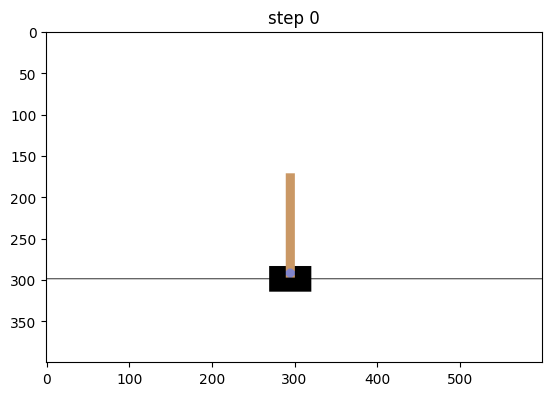

TypeError: cannot pickle 'pygame.Surface' object

In [22]:

# from gymnasium.wrappers import Monitor

total_reward = 0  # sum of rewards
# test_env = loads(root_snapshot)  # env used to show progress

for i in count():

    root = get_root(cart_pole_env, obs)
    mcts.plan(root)
    
    # get best child
    best_child = root.select_best_leaf() # <YOUR CODE: select child with the highest mean reward>

    # take action

    if best_child.action is None:
      print("Finished with reward = ", total_reward)
      break

    obs, r, terminated, truncated, _ = cart_pole_env.step(best_child.action)

    done = terminated or truncated
    
    # show image
    clear_output(True)
    plt.title("step %i" % i)
    plt.imshow(cart_pole_env.render())
    plt.show()

    cart_pole_env.close()
    
    total_reward += r
    if done:
        print("Finished with reward = ", total_reward)
        break

    # discard unrealized part of the tree [because not every child matters :(]
    # for child in root.children:
    #     if child != best_child:
    #         child.safe_delete()

    # if best_child.is_done():
    #     print("1 Finished with reward = ", total_reward)
    #     break

    # if best_child.is_leaf():
    #   best_child.expand()

    # declare best child a new root
    # cart_pole_env.close()
    

    # assert not root.is_leaf(), \
    #     "We ran out of tree! Need more planning! Try growing the tree right inside the loop."

    # You may want to run more planning here
    # <YOUR CODE>

